# Intro. ML Final Project

By Dave Lu, Alina Chen, Jin Rong Song

In [1]:
import pandas as pd
import numpy as np
import torch
import joblib

# set this flag to True if you want to train the model (takes under a minute to run the entire notebook on a Ryzen 7 3750H CPU + GTX 1660Ti GPU)
# set this flag to False if you do not want to train the model (will download the models and evaluate them)
train_models = False

# can only save models to local storage if train_models == True
save_models = False

Loading the data into Numpy arrays. Also downloads the models if we want to simply evaluate the models.

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/daveylu/10315-project/main/data.csv")

X = data[["Variance", "Skewness", "Curtosis", "Entropy"]]
y = data["Class"]

X = X.to_numpy()
y = y.to_numpy()

if(train_models == False):
    !curl https://raw.githubusercontent.com/daveylu/10315-project/main/random_forest.joblib --output random_forest.joblib
    !curl https://raw.githubusercontent.com/daveylu/10315-project/main/weights.pt --output weights.pt

# Random Forest Classifier

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix

test_size = 0.2 # fractional size of the test dataset

# randomly splits entire dataset into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size) 

# find number of samples in our test dataset
N = X_test.shape[0]

if(train_models == True):
    clf = RandomForestClassifier()              # initialize random forest classifier object
    clf.fit(X_train, y_train)                   # fit the classifier to our training dataset

    if(save_models == True):
        joblib.dump(clf, "random_forest.joblib") # saves the random forest classifier to a file

else:
    clf = joblib.load("random_forest.joblib") # reads the random forest classifier from a file
    
y_pred_proba = clf.predict_proba(X_test)    # predict the probabilities of the samples in the test dataset being real or counterfeit
y_pred = clf.predict(X_test)                # predict the labels of the samples: real or counterfeit
loss = log_loss(y_test, y_pred_proba)       # compute cross entropy loss using our predicted probabilities and true labels.
accuracy = np.sum(y_test == y_pred) / N     # compute accuracy of our labeling

print(f"Validation Cross-Entropy Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")
print("Confusion Matrix:")
confusion_matrix(y_pred, y_test)

Validation Cross-Entropy Loss: 0.03694115489216537
Validation Accuracy: 0.9890909090909091
Confusion Matrix:


array([[144,   1],
       [  2, 128]], dtype=int64)

# Neural Network

Creation of PyTorch dataset

In [4]:
from torch.utils.data import Dataset, DataLoader, random_split

# need to create copies or else pytorch gets unhappy
X_copy = np.copy(X) 
y_copy = np.copy(y)

class BankNotesDataset(Dataset):

    def __init__(self):
        self.data = torch.tensor(X_copy, dtype = torch.float32)
        self.labels = torch.tensor(y_copy, dtype = torch.float32)

    def __len__(self):
        return X.shape[0]
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]

# randomly splits our dataset into train and validation datasets with corresponding fractional sizes
train_dataset, test_dataset = random_split(BankNotesDataset(), [0.8, 0.2])

# create dataloader objects for our train and validation datasets
train_DL = DataLoader(train_dataset, batch_size = 16, shuffle = True)
valid_DL = DataLoader(test_dataset, batch_size = 16, shuffle = True)

Creation of PyTorch Neural Net

In [5]:
import torch.nn as nn

input_dim = X.shape[1] # number of dimensions of our original input sample

class NeuralNet(nn.Module):

    def __init__(self):
        super(NeuralNet, self).__init__()
        
        self.hidden_layer_1 = nn.Linear(in_features = input_dim, out_features = input_dim * 2)
        self.relu = nn.ReLU()
        self.hidden_layer_2 = nn.Linear(in_features = input_dim * 2, out_features = input_dim * 3)
        self.sigmoid = nn.Sigmoid()
        self.hidden_layer_3 = nn.Linear(in_features = input_dim * 3, out_features = input_dim * 3)
        self.leaky_relu = nn.LeakyReLU()
        self.hidden_layer_4 = nn.Linear(in_features = input_dim * 3, out_features = 1)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        output_1 = self.hidden_layer_1(x)
        output_2 = self.relu(output_1)
        output_3 = self.hidden_layer_2(output_2)
        output_4 = self.sigmoid(output_3)
        output_5 = self.hidden_layer_3(output_4)
        output_6 = self.leaky_relu(output_5)
        output_7 = self.hidden_layer_4(output_6)
        y_pred = self.final_activation(output_7)

        return y_pred

# initialize our model with our constructed neural net
model = NeuralNet()

Creation of Training Loop (~~stolen~~ borrowed from HW7)

In [6]:
loss_fn = torch.nn.BCELoss() # use binary cross-entropy loss as our loss function
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# use Adam optimizer to speed it up (not that it actually needs speeding up)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# code taken from HW7
def evaluate_DL(model, dl, loss_fn):
    model = model.to(device)
    
    with torch.no_grad():
        lossSum = 0
        nCorrect = 0
        for X, y in dl:
            X = X.to(device)
            y = torch.reshape(y, (-1, 1)) # must reshape, as the loss function requires a 2D column vector, not a 1D vector
            y = y.to(device)
            yhat = model(X)

            lossSum += loss_fn(yhat, y) * X.shape[0]

            predictions = torch.where(yhat > 0.5, 1, 0)
            truth = torch.where(y > 0.5, 1, 0)
            nCorrect += torch.sum(predictions == truth)

        numSamples = len(dl.dataset)
        avgLoss = lossSum / numSamples
        acc = nCorrect / numSamples
    return avgLoss.item(), acc.item()

# code taken from HW7
def evaluate(model, trainDL, validDL, lossfn):
    trainLoss, trainAcc = evaluate_DL(model, trainDL, lossfn)
    validLoss, validAcc = evaluate_DL(model, validDL, lossfn)
    return trainLoss, trainAcc, validLoss, validAcc

# code taken from HW7
def train(model, trainDL, validDL, loss_fn, opt, epochs = 10):
    trainLosses = []
    trainAccs   = []
    validLosses = []
    validAccs   = []

    trainLoss, trainAcc, validLoss, validAcc = evaluate(model, trainDL, validDL, loss_fn)
    trainLosses.append(trainLoss)
    trainAccs.append(trainAcc)
    validLosses.append(validLoss)
    validAccs.append(validAcc)

    model = model.to(device)
    for e in range(epochs):
        for X, y in trainDL:
            X = X.to(device)
            y = torch.reshape(y, (-1, 1)) # must reshape, as the loss function requires a 2D column vector, not a 1D vector
            y = y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            opt.zero_grad()
            loss.backward()
            opt.step()

        trainLoss, trainAcc, validLoss, validAcc = evaluate(model, trainDL, validDL, loss_fn)
        trainLosses.append(trainLoss)
        trainAccs.append(trainAcc)
        validLosses.append(validLoss)
        validAccs.append(validAcc)

    return model, trainLosses, trainAccs, validLosses, validAccs

Creation of Plotting Code (~~stolen~~ borrowed from HW7)

In [7]:
import matplotlib.pyplot as plt

# code taken from HW7
def plot_statistics(epochs, trainLosses, trainAccs, validLosses, validAccs):
    fig, axes = plt.subplots(1,2)
    xdata = np.arange(epochs+1)
    
    # plot the losses
    axis = axes[0]
    axis.plot(xdata, trainLosses, label="Train")
    axis.plot(xdata, validLosses, label="Valid")
    axis.set_xlabel("# Epochs")
    axis.set_ylabel("Average Loss")
    axis.set_title("Cross-Entropy Loss per Epoch")
    axis.grid()
    axis.legend()
    
    # plot the accuracies
    axis = axes[1]
    axis.plot(xdata, trainAccs, label="Train")
    axis.plot(xdata, validAccs, label="Valid")
    axis.set_xlabel("# Epochs")
    axis.set_ylabel("Accuracy")
    axis.set_title("Accuracy per Epoch")
    axis.grid()
    axis.legend()    

Training the Neural Net and Plotting Results

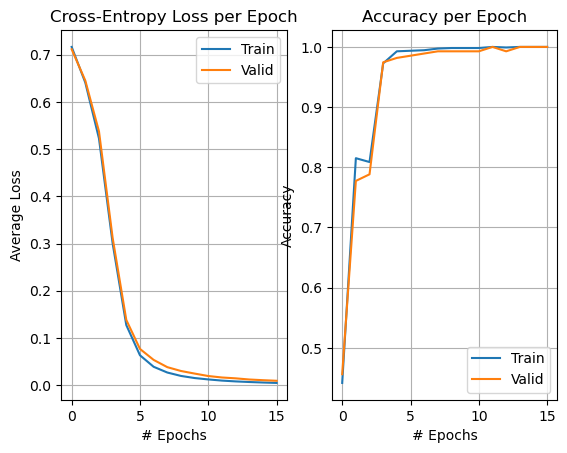

In [8]:
if(train_models == True):
    epochs = 15
    # train our neural network
    model, trainLosses, trainAccs, validLosses, validAccs = train(model, train_DL, valid_DL, loss_fn, optimizer, epochs = epochs)

    if(save_models == True):
        torch.save(model.state_dict(), "weights.pt") # saves our neural net weights into a file

    # plot how our neural network progressed over time
    plot_statistics(epochs, trainLosses, trainAccs, validLosses, validAccs)

else:
    model.load_state_dict(torch.load("weights.pt", map_location = device))     # loads our neural net weights into the neural net
    model.eval()                                        # puts our neural net into evaluation mode

    trainLoss, trainAcc, validLoss, validAcc = evaluate(model, train_DL, valid_DL, loss_fn)
    validLosses = [validLoss]
    validAccs = [validAcc]

In [9]:
print(f"Validation Cross-Entropy Loss: {validLosses[-1]}")
print(f"Validation Accuracy: {validAccs[-1]}")

Validation Cross-Entropy Loss: 0.00943012535572052
Validation Accuracy: 1.0
